<a href="https://colab.research.google.com/github/emmbiz/MedEye/blob/master/train_xray_classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sample Training Iteration

In [ ]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Helper libraries
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import os

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Create datasets for training and validation

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
data_folder = '/content/drive/MyDrive/chest-x-ray-data/train_data'

print("[INFO] loading images...")
image_size = (224, 224)
data = []
labels = []
image_paths = list(paths.list_images(data_folder))
for image_path in image_paths:
    # Load the input image (224x224) and preprocess it
    img = load_img(image_path, target_size=image_size)
    image = img_to_array(img) / 255.0

    # Extract the class label from the filename
    label = image_path.split(os.path.sep)[-2]

    # Update the data and labels lists respectively
    data.append(image)
    labels.append(label)

# Convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
print("[INFO] data: {} images ({:.2f}MB)".format(len(image_paths), data.nbytes / (1024 * 1000.0)))

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Show each of the possible class labels
print("[INFO] class labels:")
for (number, label) in enumerate(lb.classes_):
    print("{}. {}".format(number + 1, label))

# Partition the data into training and testing splits (80%-20% respectively)
(training_images, testing_images, training_labels, testing_labels) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] loading images...
[INFO] data: 1050 images (617.40MB)
[INFO] class labels:
1. covid
2. normal
3. not xray


### Display few training images

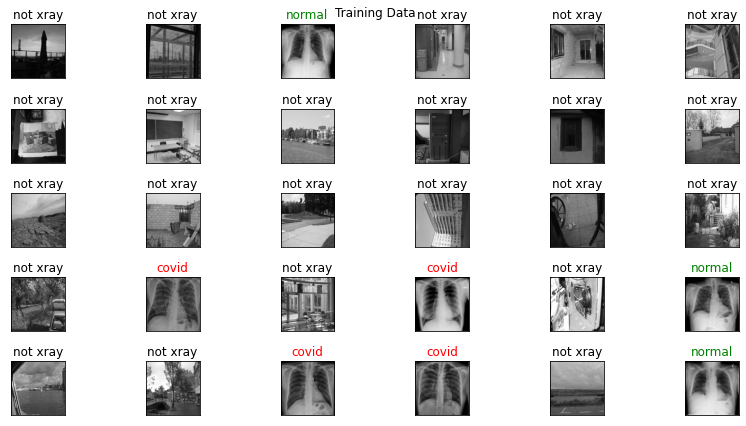

In [ ]:
# Show sample images from the training dataset
plt.figure(figsize=(12, 6))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplots_adjust(hspace=0.5)
    plt.imshow(training_images[i], cmap=plt.cm.gray)
    index = np.argmax(training_labels[i])
    color = 'red' if index == 0 else 'green' if index == 1 else 'black'
    plt.title(lb.classes_[index], color=color)
plt.suptitle("Training Data")
plt.tight_layout()
plt.show()

### Perform data augmentation

[INFO] performing data augmentation...


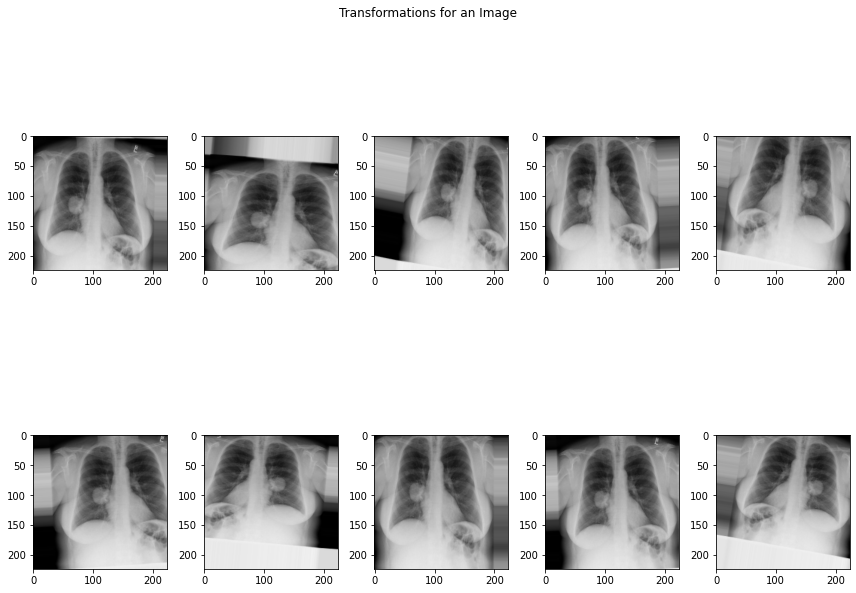

In [ ]:
# Construct the image generator for data augmentation
print("[INFO] performing data augmentation...")
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode="nearest")

# Generate augmented data from dataset
batch_size = 32
train_generator = data_gen.flow(training_images, training_labels, batch_size=batch_size)
test_generator = data_gen.flow(testing_images, testing_labels)

# Plot a random augmented image with transformations
augmented_imgs = [train_generator[0][0][0] for i in range(10)]
plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(augmented_imgs[i], cmap=plt.cm.gray)
plt.suptitle("Transformations for an Image")
plt.tight_layout()
plt.show()

### Define the CNN classifier network

In [ ]:
# Perform Transfer Learning with MobileNetV2 network
# Load the MobileNetV2 network
base_model = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Construct the head of the model to place on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
n_classes = len(lb.classes_)
head_model = Dense(n_classes, activation="softmax")(head_model)

# Construct actual model for training
model = Model(inputs=base_model.input, outputs=head_model)

# Initialize the initial learning rate and number of epochs
INIT_LR = 1e-4
EPOCHS = 100

# Compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# Show the full model summary
print(model.summary())

9420800/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
     

### Train the model

In [ ]:
# Stop training when 99% accuracy is reached
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = 0.99
        EPOCHS = epoch
        if (logs.get('accuracy') > accuracy):
            print("\n[INFO] Reached {}% accuracy, cancelling training...".format(accuracy * 100))
            self.model.stop_training = True

callbacks = myCallback()

# Train the head of the network for 100 epochs
print("[INFO] training head...")
hist = model.fit(
	train_generator,
	steps_per_epoch=len(training_images) // batch_size,
    validation_data=test_generator,
	validation_steps=len(testing_images) // batch_size,
    callbacks=[callbacks],
	epochs=EPOCHS)

print("[INFO] finished training model.")

[INFO] training head...
Epoch 1/100
26/26 [==============================] - 38s 1s/step - loss: 0.9530 - accuracy: 0.6225 - val_loss: 0.4588 - val_accuracy: 0.7812
Epoch 2/100
26/26 [==============================] - 34s 1s/step - loss: 0.3622 - accuracy: 0.8601 - val_loss: 0.2158 - val_accuracy: 0.9375
Epoch 3/100
26/26 [==============================] - 34s 1s/step - loss: 0.2711 - accuracy: 0.8899 - val_loss: 0.2168 - val_accuracy: 0.8802
Epoch 4/100
26/26 [==============================] - 34s 1s/step - loss: 0.2417 - accuracy: 0.8923 - val_loss: 0.1784 - val_accuracy: 0.9271
Epoch 5/100
26/26 [==============================] - 34s 1s/step - loss: 0.2097 - accuracy: 0.9121 - val_loss: 0.1700 - val_accuracy: 0.9271
Epoch 6/100
26/26 [==============================] - 34s 1s/step - loss: 0.1981 - accuracy: 0.9171 - val_loss: 0.1378 - val_accuracy: 0.9583
Epoch 7/100
26/26 [==============================] - 34s 1s/step - loss: 0.1537 - accuracy: 0.9406 - val_loss: 0.1671 - val_accura

### Evaluate the model

[INFO] evaluating network...
7/7 [==============================] - 7s 933ms/step - loss: 0.0593 - accuracy: 0.9857
[INFO] test accuracy: 0.976190447807312
[INFO] classification report:
              precision    recall  f1-score   support

       covid       0.90      0.93      0.92        30
      normal       0.93      0.90      0.92        30
    not xray       1.00      1.00      1.00       150

    accuracy                           0.98       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.98      0.98      0.98       210



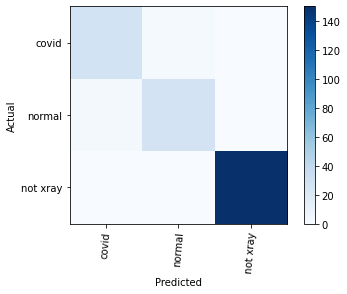

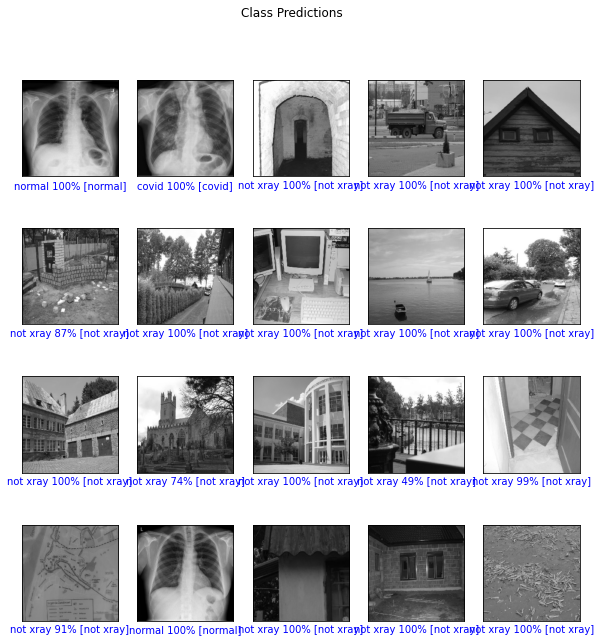

In [12]:
# Evaluate model using images in the testing dataset
print("[INFO] evaluating network...")
test_loss, test_acc = model.evaluate(testing_images, testing_labels)
model.evaluate(test_generator)
print("[INFO] test accuracy:", test_acc)

# Make predictions on the testing dataset
class_predictions = model.predict(testing_images)
#class_predictions = model.predict(testing_images, batch_size=batch_size)
# Find the index of the label with the largest predicted probability
predIdxs = np.argmax(class_predictions, axis=1)
# Get the index of the true label
trueIdxs = np.argmax(testing_labels, axis=1)

# Use SciKit-Learn to show a classification report and plot a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Show a classification report
print("[INFO] classification report:")
print(classification_report(testing_labels.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# Plot a confusion matrix
cm = confusion_matrix(trueIdxs, predIdxs)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=85)
plt.yticks(tick_marks, lb.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot random test images with their predicted labels
plt.figure(figsize=(10, 10))
for i in range(20):
  ax = plt.subplot(4, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  # plt.subplots_adjust(wspace=0.3)
  plt.subplots_adjust(hspace=0.5)

  index = random.randint(0, len(predIdxs) - 1)
  plt.imshow(testing_images[index], cmap=plt.cm.gray)

  color = 'blue' if predIdxs[index] == trueIdxs[index] else 'red'
  plt.xlabel("{} {:2.0f}% [{}]".format(lb.classes_[predIdxs[index]],
                                       100 * np.max(class_predictions[i]),
                                       lb.classes_[trueIdxs[index]]), color=color)
plt.suptitle("Class Predictions")
#plt.tight_layout()
plt.show()

### Plot test results

[INFO] generating plots...


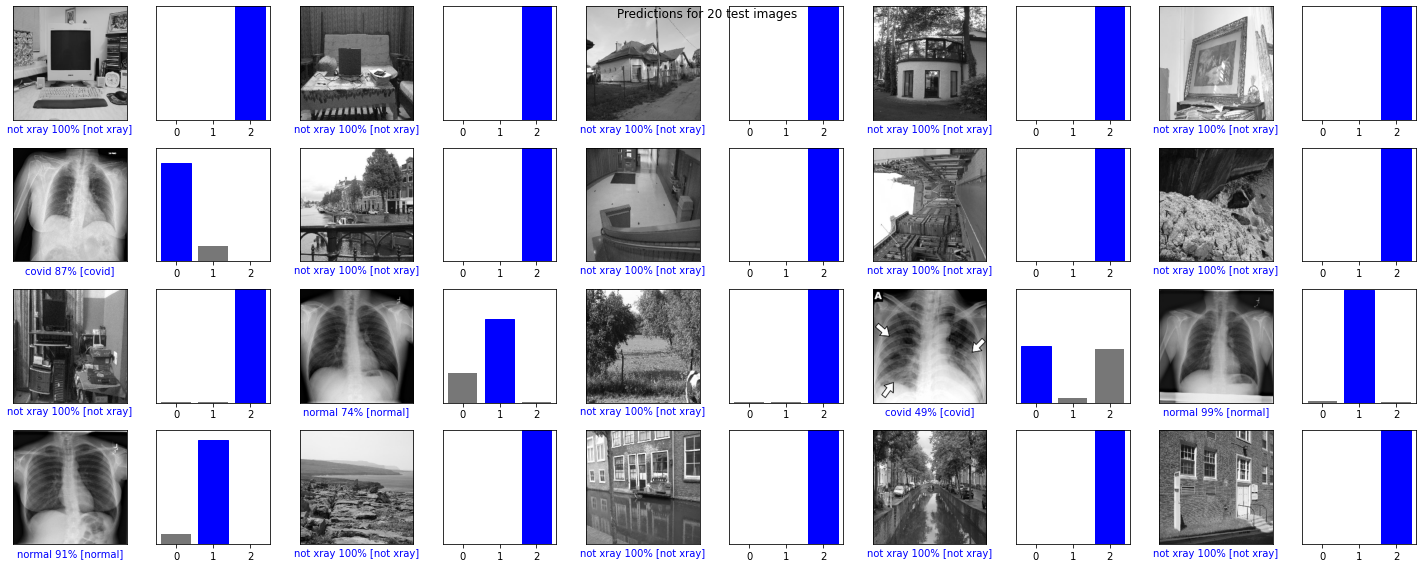

In [13]:
# Helper functions for plotting results
def plot_image(predictions, true_label, img):
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel("{} {:2.0f}% [{}]".format(lb.classes_[predicted_label],
                                         100 * np.max(predictions),
                                         lb.classes_[true_label]), color=color)

def plot_value_array(predictions, true_label):
    plt.xticks(range(len(lb.classes_)))
    plt.yticks([])
    plt.grid(False)

    thisplot = plt.bar(range(len(lb.classes_)), predictions, color="#777777")
    plt.ylim([0, 1])

    predicted_label = np.argmax(predictions)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot test images with their predicted and true labels
print("[INFO] generating plots...")
num_rows = 4
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  image_plt = np.squeeze(testing_images[i])
  true_label = np.argmax(testing_labels[i])
  #index = random.randint(0, len(predIdxs) - 1)
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_image(class_predictions[i], true_label, image_plt)
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
  plot_value_array(class_predictions[i], true_label)
plt.suptitle("Predictions for {} test images".format(num_images))
plt.tight_layout()
plt.show()

### Plot Training Loss and Accuracy

[INFO] generating training loss and accuracy plots...


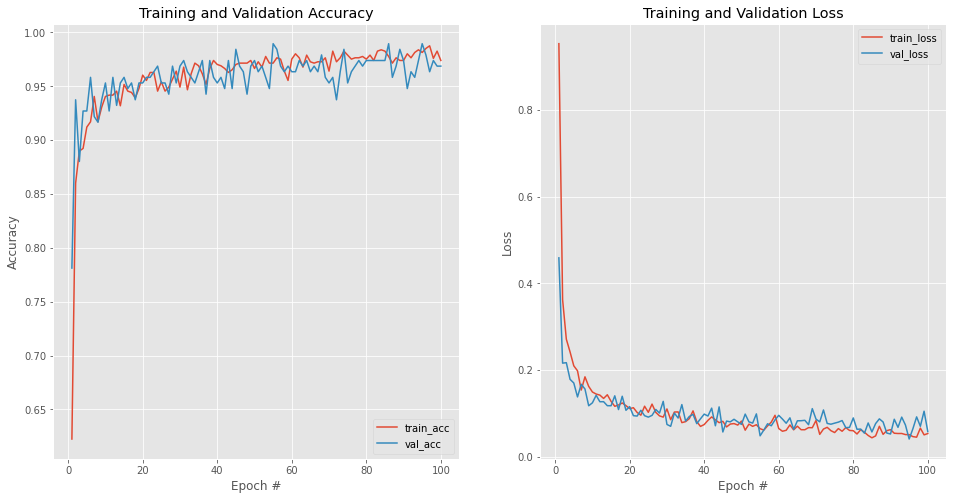

In [15]:
# Plot the training loss and accuracy
print("[INFO] generating training loss and accuracy plots...")
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 8))
plt.style.use("ggplot")
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train_loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("plot_epoch{}".format(EPOCHS))
plt.show()

### Make predictions for new images

In [16]:
# Plot a single image with its predicted label
def classify_image(image_path, true_label):
    # Load the input image (224x224) and preprocess it
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = np.array(img_batch, dtype="float32") / 255.0

    # Predict the class label for the preprocessed image
    class_prediction = model.predict(img_preprocessed)
    # Get the class label with the largest predicted probability
    index = np.argmax(class_prediction, axis=1)[0]
    label = lb.classes_[index]

    print("This image most likely belongs to \'{}\' with a {:.2f} percent confidence."
          .format(label, 100 * np.max(class_prediction)))

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plot_image(class_prediction[0], true_label, img)
    plt.subplot(1, 2, 2)
    plot_value_array(class_prediction[0], true_label)
    plt.suptitle("Class Prediction")
    plt.show()

label_map = {'covid': 0, 'normal': 1, 'not xray': 2}
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    #classify_image(image_path, label_map[label])

### Save weights and model

In [17]:
# Save the trained model and weights
print("[INFO] saving trained weights and model...")
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d _%H-%M-%S')
model_weights_name = "model_weights _ {}.h5".format(now)
export_path_wgs = "./" + model_weights_name
model.save_weights(export_path_wgs)
print("[INFO] weights saved.")
model_file_name = "model_classifier _ {}.h5".format(now)
export_path_mdl = "./" + model_file_name
model.save(export_path_mdl)
print("[INFO] model saved.")


[INFO] saving trained weights and model...
[INFO] weights saved.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


[INFO] model saved.


### Convert model to TF Lite format

In [18]:
# Convert Keras model to TF Lite format
print("[INFO] converting model to TF Lite format...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()
open("classifier_float_model _ {}.tflite".format(now), "wb").write(tflite_float_model)
# Show model size in KBs
float_model_size = len(tflite_float_model) / 1024
print('[INFO] TFLite Float model size = %dKBs.' % float_model_size)

# Re-convert the model to TF Lite using quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
open("classifier_quant_model _ {}.tflite".format(now), "wb").write(tflite_quantized_model)
# Show model size in KBs
quantized_model_size = len(tflite_quantized_model) / 1024
print('[INFO] TFLite Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

[INFO] converting model to TF Lite format...


[INFO] TFLite Float model size = 9293KBs.


[INFO] TFLite Quantized model size = 2738KBs,
which is about 29% of the float model size.


### Evaluate TF Lite model

In [20]:
# Evaluate the TF Lite model using images in the test dataset
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the test dataset
  prediction_digits = []
  for test_image in testing_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if (prediction_digits[index] == testing_labels[index]).any():
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

print("[INFO] evaluating TF Lite models...")
# Evaluate the TF Lite float model
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('[INFO] Float model accuracy = %.4f' % float_accuracy)

# Evaluate the TF Lite quantized model
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('[INFO] Quantized model accuracy = %.4f' % quantized_accuracy)
print('[INFO] Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


[INFO] evaluating TF Lite models...
[INFO] Float model accuracy = 0.2857
[INFO] Quantized model accuracy = 0.2857
[INFO] Accuracy drop = 0.0000


### Download the TF Lite model

In [25]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(lb.classes_))
  
try:
  from google.colab import files
  files.download("classifier_float_model _ {}.tflite".format(now))
  files.download("classifier_quant_model _ {}.tflite".format(now))
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>